# Optimization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

### Initialize dataset
We use `normalize` configuration parameter to enable/disable normalization

In [ ]:

class Cifar10(torchvision.datasets.CIFAR10):
  def __init__(self, train: bool, normalize=False):
    super().__init__(root='~/data', train=train, download=True)
    self.data = self.data.astype(np.float32)
    if normalize:
      self.data = self.data / 255 - 0.5

  def __getitem__(self, idx):
    return self.data[idx], self.targets[idx]


normalize = False # True
data_train = Cifar10(train=True, normalize=normalize)
data_train, data_valid = torch.utils.data.random_split(data_train, (45000, 5000))
data_test = Cifar10(train=False, normalize=normalize)

Files already downloaded and verified
Files already downloaded and verified


### Load training, test and validation data

In [ ]:
kwargs = {'batch_size': 100, 'num_workers': 2}
loader_train = torch.utils.data.DataLoader(data_train, **kwargs, shuffle=True)
loader_valid = torch.utils.data.DataLoader(data_valid, **kwargs)
loader_test = torch.utils.data.DataLoader(data_test, **kwargs)

### Now create a Multi-layer perceptron with 1 hidden layer
Provide configuration parameters to your function to change number of hidden neurons and enable/disable `BatchNorm` layer which is applied after `ReLU`

Remember that you can create MLP in PyTorch using 2 different ways: either by extending `nn.module` class or using `nn.sequntial` module. Refer solution of 3rd assignment for more details.

In [ ]:
##### YOUR CODE GOES HERE #####

def build_mlp(n_hidden_neurons: int, use_batchnorm=False):
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(32 * 32 * 3, n_hidden_neurons),
        nn.ReLU(),
        nn.BatchNorm1d(n_hidden_neurons) if use_batchnorm else nn.Identity(),
        nn.Linear(n_hidden_neurons, 10),
    )

In [ ]:
device = torch.device('cuda')
n_hidden_neurons = 100

# Try different optimizers eg. SGD, ADAM
# Check https://pytorch.org/docs/stable/optim.html for more details

# Try different learning rate schedulers e.g. StepLR, ReduceLROnPlateau and also fixed learning rate
# Check https://pytorch.org/docs/stable/optim.html for more details


# model = build_mlp(n_hidden_neurons, use_batchnorm=True).to(device)
# model = build_mlp(n_hidden_neurons, use_batchnorm=False).to(device)

# lr = 5e-2
# opt = torch.optim.SGD(model.parameters(), lr=lr)
# opt = torch.optim.Adam(model.parameters(), lr=lr)

# sched = None # for fixed
# sched = torch.optim.lr_scheduler.StepLR(opt, step_size=30, gamma=0.1)
# sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=3, min_lr=1e-6, verbose=True)


def optimize_model(model, loader_train, loader_valid, opt, sched):
  train_losses, train_accuracies = [], []
  valid_losses, valid_accuracies = [], []

  t = tqdm(range(50))
  for epoch in t:

      # training step
      epoch_losses = []
      correct, total = 0, 0

      model.train()

      for x, y in loader_train:
          x, y = x.to(device), y.to(device)
          logits = model(x)  # logits: common name for the output before softmax activation
          log_probs = F.log_softmax(logits, dim=1)  # numerically stable version of log(softmax(logits))
          loss = F.nll_loss(log_probs, y)  # negative log likelihood loss

          opt.zero_grad()
          loss.backward()
          opt.step()

          epoch_losses.append(loss.item())
          total += len(x)
          correct += (torch.argmax(logits, dim=1) == y).sum().item()

      train_losses.append(np.mean(epoch_losses))
      train_accuracies.append(correct / total)

      # validation step

      epoch_losses = []
      correct, total = 0, 0

      model.eval()

      for x, y in loader_valid:
          x, y = x.to(device), y.to(device)
          with torch.no_grad():  # we don't want to update weights based on the validation set
              logits = model(x)
          loss = F.cross_entropy(logits, y) # same as F.nll_loss(F.log_softmax(...))

          epoch_losses.append(loss.item())
          total += len(x)
          correct += (torch.argmax(logits, dim=1) == y).sum().item()

      valid_losses.append(np.mean(epoch_losses))
      valid_accuracies.append(correct / total)

      if sched is not None:
          sched.step(valid_losses[-1])

      t.set_description(f'loss, val: {valid_losses[-1]:.2f}, acc, val: {valid_accuracies[-1]:.2f}')

  return train_losses, valid_losses, train_accuracies, valid_accuracies

### Visualize results

In [ ]:
def visualize_results(train_losses, valid_losses, train_accuracies, valid_accuracies):
  plt.figure(figsize=(10, 4))

  plt.subplot(1, 2, 1)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  p = plt.plot(train_losses, label='train')
  plt.plot(valid_losses, label='valid')
  plt.legend()
  plt.grid()

  plt.subplot(1, 2, 2)
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  p = plt.plot(train_accuracies, label='train')
  plt.plot(valid_accuracies, label='valid')
  plt.legend()
  plt.grid()

  plt.tight_layout()
  plt.show()

### Case 1: Normalization=False, Batchnorm=True, SGD

  0%|          | 0/50 [00:00<?, ?it/s]

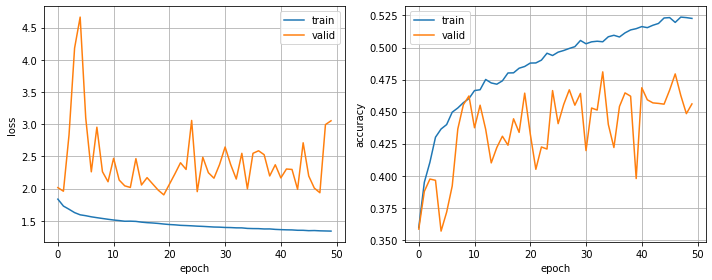

In [ ]:
model = build_mlp(n_hidden_neurons, use_batchnorm=True).to(device)

lr = 5e-2
opt = torch.optim.SGD(model.parameters(), lr=lr)

sched = None # for fixed

tl, vl, ta, va = optimize_model(model, loader_train, loader_valid, opt, sched)
visualize_results(tl, vl, ta, va)

### Case 2: Normalization=False, Batchnorm=True, Adam

  0%|          | 0/50 [00:00<?, ?it/s]

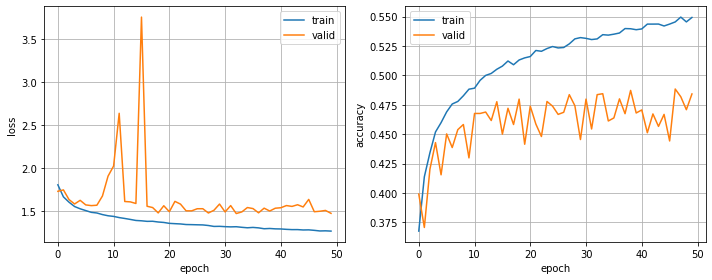

In [ ]:
model = build_mlp(n_hidden_neurons, use_batchnorm=True).to(device)

opt = torch.optim.Adam(model.parameters())

sched = None # for fixed

tl, vl, ta, va = optimize_model(model, loader_train, loader_valid, opt, sched)
visualize_results(tl, vl, ta, va)

### Case 3: Normalization=False, Batchnorm=True, Adam, ReduceLROnPlateau

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch    16: reducing learning rate of group 0 to 1.0000e-04.
Epoch    20: reducing learning rate of group 0 to 1.0000e-05.
Epoch    27: reducing learning rate of group 0 to 1.0000e-06.


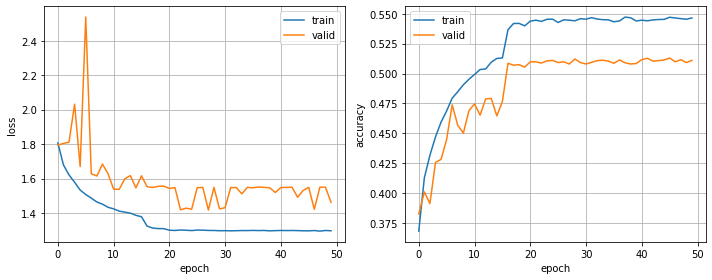

In [ ]:
model = build_mlp(n_hidden_neurons, use_batchnorm=True).to(device)

opt = torch.optim.Adam(model.parameters())

sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=3, min_lr=1e-6, verbose=True)

tl, vl, ta, va = optimize_model(model, loader_train, loader_valid, opt, sched)
visualize_results(tl, vl, ta, va)

### Case 4: Normalization=False, Batchnorm=True, Adam, StepLR

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


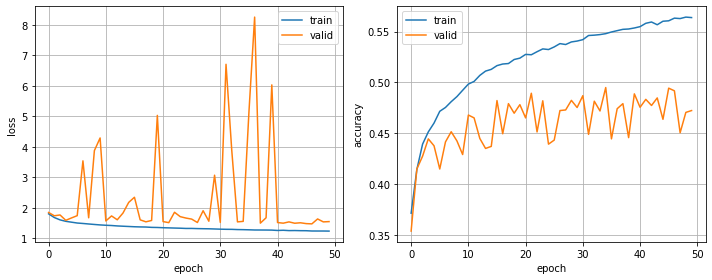

In [ ]:
model = build_mlp(n_hidden_neurons, use_batchnorm=True).to(device)

opt = torch.optim.Adam(model.parameters())

sched = torch.optim.lr_scheduler.StepLR(opt, step_size=30, gamma=0.1)

tl, vl, ta, va = optimize_model(model, loader_train, loader_valid, opt, sched)
visualize_results(tl, vl, ta, va)

### Now lets re-rerun the experiments without `BatchNorm`

### Case 1: Normalization=False, Batchnorm=False, SGD

  0%|          | 0/50 [00:00<?, ?it/s]

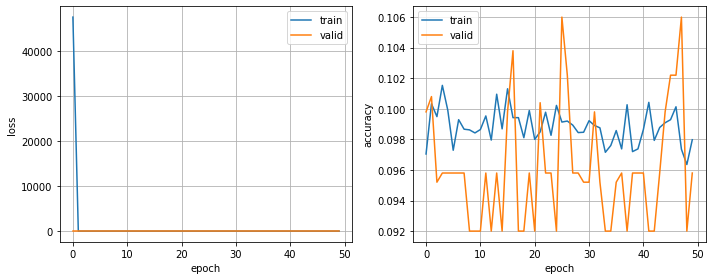

In [ ]:
model = build_mlp(n_hidden_neurons, use_batchnorm=False).to(device)

lr = 5e-2
opt = torch.optim.SGD(model.parameters(), lr=lr)

sched = None # for fixed

tl, vl, ta, va = optimize_model(model, loader_train, loader_valid, opt, sched)
visualize_results(tl, vl, ta, va)

### Case 2: Normalization=False, Batchnorm=False, Adam

  0%|          | 0/50 [00:00<?, ?it/s]

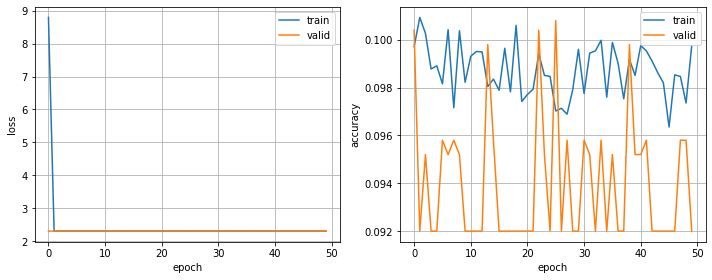

In [ ]:
model = build_mlp(n_hidden_neurons, use_batchnorm=False).to(device)

opt = torch.optim.Adam(model.parameters())

sched = None # for fixed

tl, vl, ta, va = optimize_model(model, loader_train, loader_valid, opt, sched)
visualize_results(tl, vl, ta, va)

### Case 3: Normalization=False, Batchnorm=False, Adam, ReduceLROnPlateau

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Epoch    10: reducing learning rate of group 0 to 1.0000e-05.
Epoch    14: reducing learning rate of group 0 to 1.0000e-06.


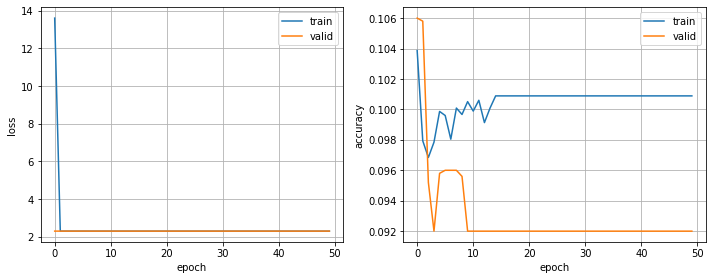

In [ ]:
model = build_mlp(n_hidden_neurons, use_batchnorm=False).to(device)

opt = torch.optim.Adam(model.parameters())

sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=3, min_lr=1e-6, verbose=True)

tl, vl, ta, va = optimize_model(model, loader_train, loader_valid, opt, sched)
visualize_results(tl, vl, ta, va)

### Case 4: Normalization=False, Batchnorm=False, Adam, StepLR

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


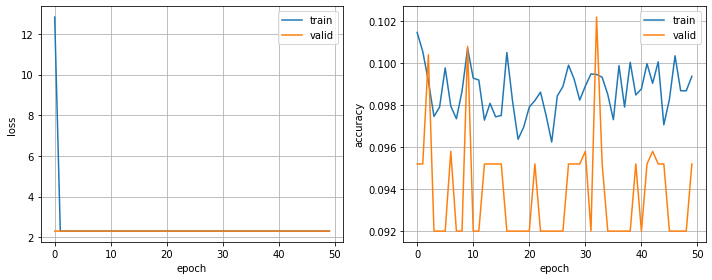

In [ ]:
model = build_mlp(n_hidden_neurons, use_batchnorm=False).to(device)

opt = torch.optim.Adam(model.parameters())

sched = torch.optim.lr_scheduler.StepLR(opt, step_size=30, gamma=0.1)

tl, vl, ta, va = optimize_model(model, loader_train, loader_valid, opt, sched)
visualize_results(tl, vl, ta, va)